In [209]:
from nltk.corpus import stopwords
from ftfy import fix_text
import spacy
import re
import json
import pickle
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

## NLP-pipeline Classifier: CountVectorizer, TF-idf, SVC

In [255]:
class NLPModel:
    
    LABEL_DICT = { # mapping the model's output to text labels
        0: 'low',
        1: 'medium',
        2: 'high',
        3: 'very_high'    
    }

    QUANTILE_DICT = { # mapping the model's output to text labels
        0: [0, 0.17222840499877926],
        1: [0.17222840499877927, 0.8060877380371094],
        2: [0.8060877380371095, 2.8519862670898437],
        3: [2.8519862670898437, 300]   # we set a random high threshold, higer than out current 150sth max 
    }
    
    
    _scorers = {
            'f1_score': make_scorer(f1_score, average='macro'),
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score)
          }

    
    def __init__(self, load_model=False, model_version="1"):
        """NLPModel's constructor
        
        Args:
            model_version (str): verion's name
            load_model (bool): if the model exists and must be loaded
            
        """
        self.model_version = model_version     
        
        if load_model:
            self._retrieve_model()
            

            
    @classmethod
    def map_value_to_range(cls, df, target_column):
        '''
        Labels the target colum of the input df according to the QUANTILE_DICT and LABEL_DICT
        '''
        def convert_value(v):
            # return the key for which v is in the range of the key's value
            for key, value in cls.QUANTILE_DICT.items():
                if v >= value[0] and v <= value[1]:
                    return key
            raise ValueError(f"Invalid value: {v}")
            
        for i in range(len(df)):
            value = df[target_column][i]
            df[target_column][i] = convert_value(value)
            
        return df
            
        
    def find_best_parameters(self, x, y):
        
        text_nlp = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('svc', SVC())])

        # Create grid of parameters to test through cross-validation
        parameters = {
            'vect__ngram_range': [(1,2),(1,3)],
            'vect__max_df': [0.8],
            'vect__max_features': [10000], # we limit it to the best 10k features since speeches are long (performance reasons)
            'tfidf__use_idf': [True],
            'svc__kernel': ['rbf', 'sigmoid'],
            'svc__gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4, "scale"],
            'svc__C':  [0.1, 1, 10]
        }

        gs_nlp = GridSearchCV(text_nlp, parameters, cv=5, verbose=10)
        gs_nlp.fit(x, y)
        
        output_dict = {}
        for param_name in sorted(parameters.keys()):
            output_dict[param_name] = gs_nlp.best_params_[param_name]
            
        with open(f"gs_nlp_{self.model_version}.json", "w") as write_file:
            json.dump(output_dict, write_file, indent=4)
       
    
    def train_model(self, x, y, vect_params: dict, svc_params: dict):
        
        """This method trains the speech model and overwrites the existing one if the same type and version is provided (if same version applies)"""
        
        class NpEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return json.JSONEncoder.default(self, obj)
            
        text_nlp = Pipeline([
            ('vect', CountVectorizer(max_features=10000, **vect_params)),
            ('tfidf', TfidfTransformer()),
            ('svc', SVC(**svc_params))
        ])
        
        # Train the model
        print(' Training the model...')
        results = cross_validate(text_nlp, x, y, cv=5, scoring=self._scorers, error_score="raise")
        text_nlp.fit(x, y)
        

        # Save model
        print(' Saving the model...')
        filename = f"nlp_model_{self.model_version}.pkl"
        pickle.dump(text_nlp, open(filename, 'wb'))
        print(' Saving validation scores...')
        with open(f"nlp_model_{self.model_version}_validation.json", "w") as write_file:
            json.dump(results, write_file, indent=4, cls=NpEncoder)
        

    def _retrieve_model(self):
        """This method gets the model from the current directory"""
    
        print('Loading model from local machine...')
        path_to_model = f'./nlp_model_{self.model_version}.pkl'
        print(path_to_model)
        model = pickle.load(open(path_to_model, 'rb'))
        self.model = model
        print('Model loaded')
    

    def predict(self, x):
        
        """This method predicts using the loaded model"""
        y_pred = self.model.predict(x)
        y_pred_relabeled = [self.LABEL_DICT[label] for label in y_pred]
        return y_pred_relabeled

        

## Remap the renewable energy/capita to classes (percentile ranges)

In [173]:
renewable_energy = pd.read_csv('per-capita-renewables (1).csv')
renewable_energy = renewable_energy[~renewable_energy.Code.isna()].reset_index(drop=True)
renewable_energy.rename(columns={"Renewables per capita (kWh - equivalent)" : 'renewable_capita'}, inplace=True)
renewable_energy.head()

,Entity,Code,Year,renewable_capita
0,Algeria,DZA,1965,0.094240
1,Algeria,DZA,1966,0.081358
2,Algeria,DZA,1967,0.091327
3,Algeria,DZA,1968,0.121841
4,Algeria,DZA,1969,0.075913


In [174]:
renewable_energy.renewable_capita.max()

153.88340625

In [175]:
renewable_energy.index

RangeIndex(start=0, stop=4292, step=1)

In [176]:
p_25 = renewable_energy.renewable_capita.quantile(0.25)
p_50 = renewable_energy.renewable_capita.quantile(0.50)
p_75 = renewable_energy.renewable_capita.quantile(0.75)

print(p_25, p_50, p_75)

0.17222840499877926 0.8060877380371094 2.8519862670898437


In [177]:
labels = ['low', 'medium', 'high', 'very_high']

In [178]:
renewable_energy_relabeled = NLPModel.map_value_to_range(renewable_energy, "renewable_capita")
# model = NLPModel(model_version=1)
# model.
renewable_energy_relabeled

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Entity,Code,Year,renewable_capita
0,Algeria,DZA,1965,0.0
1,Algeria,DZA,1966,0.0
2,Algeria,DZA,1967,0.0
3,Algeria,DZA,1968,0.0
4,Algeria,DZA,1969,0.0
...,...,...,...,...
4287,World,OWID_WRL,2017,2.0
4288,World,OWID_WRL,2018,2.0
4289,World,OWID_WRL,2019,2.0
4290,World,OWID_WRL,2020,2.0


## Matchnig renewable energy entries to the speeches

In [181]:
cleaned_speeches = pd.read_csv('cleaned_model_speeches.csv', index_col=0)
cleaned_speeches[:1]

,Session,Year,ISO-alpha3 Code,Speech,Cleaned_Speech
0,25,1970,AUT,155.\t May I begin by expressing to Ambassado...,begin expressing ambassador hambro behalf dele...


In [182]:
renewable_energy_relabeled[:1]

,Entity,Code,Year,renewable_capita
0,Algeria,DZA,1965,0.0


In [225]:
data = pd.merge(cleaned_speeches, renewable_energy_relabeled,
               left_on=['ISO-alpha3 Code', 'Year'], right_on=['Code', 'Year'],
               how='inner').drop(columns=['ISO-alpha3 Code'])

In [226]:
data.head()

,Session,Year,Speech,Cleaned_Speech,Entity,Code,renewable_capita
0,25,1970,155.\t May I begin by expressing to Ambassado...,begin expressing ambassador hambro behalf dele...,Austria,AUT,3.0
1,25,1970,"33.\t Mr. President, I take great pleasure in...",president take pleasure following tradition co...,Mexico,MEX,2.0
2,25,1970,1. The delegation of Algeria is very pleased ...,delegation algeria see session assembly held p...,Algeria,DZA,0.0
3,25,1970,"176.\t Mr. President, the delegation of Ceylon...",president delegation ceylon see preside sessio...,Sri Lanka,LKA,1.0
4,25,1970,36.\t May I say to the delegation of Malaysia ...,say delegation malaysia delegation shares grie...,Philippines,PHL,1.0


In [230]:
# Our X is just trained speeches, and y is renewable_capita, so we can drop the other columns as well
# saving this separately so that we can retrieve the other feature vals for each row in case we need to

# this is for grid search: ideally it would be as much as the train, but we don't have much time
model_data_grid = data[(data.Year >= 2000) & (data.Year <= 2018)].drop(columns=['Session', 'Year', 'Speech', 'Entity', 'Code'])
# this is for training and validation
model_data_train = data[data.Year <= 2018].drop(columns=['Session', 'Year', 'Speech', 'Entity', 'Code'])
# we'll use this for testing at the end, via predict()
model_data_test = data[data.Year > 2018].drop(columns=['Session', 'Year', 'Speech', 'Entity', 'Code'])

## Finding best param combination

In [235]:
# instantiating model and setting load to false, since we're creating a new one, not using a saved one
model = NLPModel(model_version=3, load_model=False)

# separating X and y and bringing them into shape
X = model_data_grid.Cleaned_Speech.values
y = model_data_grid.renewable_capita.values

# using grid search with 5 folds to find best param values 
# for the Vectorizer, tf-idf, and the SVC classifier int the pipeline
model.find_best_parameters(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 1/5; 1/48] END svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.334 total time=  10.6s
[CV 2/5; 1/48] START svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 2/5; 1/48] END svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.336 total time=  10.2s
[CV 3/5; 1/48] START svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 3/5; 1/48] END svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_d

[CV 5/5; 5/48] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.336 total time=  10.5s
[CV 1/5; 6/48] START svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 1/5; 6/48] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.334 total time=  14.0s
[CV 2/5; 6/48] START svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 2/5; 6/48] END svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.336 total time=  13.6s
[CV 3/5; 6/48] START svc__C=0.1, svc__gamma=1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ng

[CV 4/5; 10/48] END svc__C=0.1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.336 total time=  14.0s
[CV 5/5; 10/48] START svc__C=0.1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 5/5; 10/48] END svc__C=0.1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.336 total time=  13.5s
[CV 1/5; 11/48] START svc__C=0.1, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 1/5; 11/48] END svc__C=0.1, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.600 total time=   9.4s
[CV 2/5; 11/48] START svc__C=0.1, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_

[CV 3/5; 15/48] END svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.398 total time=   9.6s
[CV 4/5; 15/48] START svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 4/5; 15/48] END svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.412 total time=   9.6s
[CV 5/5; 15/48] START svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 5/5; 15/48] END svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.384 total time=   9.6s
[CV 1/5; 16/48] START svc__C=0.1, svc__gamma=scale, svc__kernel=sigmoid, tfidf__use_idf=True

[CV 2/5; 20/48] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.412 total time=  12.8s
[CV 3/5; 20/48] START svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 3/5; 20/48] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.408 total time=  12.9s
[CV 4/5; 20/48] START svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 4/5; 20/48] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.429 total time=  12.8s
[CV 5/5; 20/48] START svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect

[CV 1/5; 25/48] END svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.334 total time=  10.7s
[CV 2/5; 25/48] START svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 2/5; 25/48] END svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.336 total time=  10.7s
[CV 3/5; 25/48] START svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 3/5; 25/48] END svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.336 total time=  10.5s
[CV 4/5; 25/48] START svc__C=1, svc__gamma=10, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ng

[CV 5/5; 29/48] END svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.709 total time=  10.3s
[CV 1/5; 30/48] START svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 1/5; 30/48] END svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.752 total time=  13.3s
[CV 2/5; 30/48] START svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 2/5; 30/48] END svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.758 total time=  13.6s
[CV 3/5; 30/48] START svc__C=1, svc__gamma=scale, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_featur

[CV 4/5; 34/48] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.758 total time=  13.0s
[CV 5/5; 34/48] START svc__C=10, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 5/5; 34/48] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.751 total time=  13.1s
[CV 1/5; 35/48] START svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 1/5; 35/48] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.759 total time=   9.7s
[CV 2/5; 35/48] START svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_

[CV 3/5; 39/48] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.734 total time=   9.1s
[CV 4/5; 39/48] START svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 4/5; 39/48] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.737 total time=   9.2s
[CV 5/5; 39/48] START svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2)
[CV 5/5; 39/48] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 2);, score=0.737 total time=   9.0s
[CV 1/5; 40/48] START svc__C=10, svc__gamma=1, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_

[CV 2/5; 44/48] END svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.484 total time=   9.0s
[CV 3/5; 44/48] START svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 3/5; 44/48] END svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.495 total time=   8.7s
[CV 4/5; 44/48] START svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3)
[CV 4/5; 44/48] END svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect__max_features=10000, vect__ngram_range=(1, 3);, score=0.505 total time=   8.6s
[CV 5/5; 44/48] START svc__C=10, svc__gamma=10, svc__kernel=sigmoid, tfidf__use_idf=True, vect__max_df=0.8, vect

## Training the model and saving validation scores

In [237]:
# separating X and y and bringing them into shape
X = model_data_train.Cleaned_Speech.values
y = model_data_train.renewable_capita.values

# inserting the JSON param combo saved by find_best_parameters() in a file in the current directory
model = NLPModel(model_version=3, load_model=False)
model.train_model(X, y, 
                  vect_params={"max_df": 0.8, "ngram_range": (1,2)}, 
                  svc_params={"kernel": "rbf", "gamma": 1, "C": 10}
                 )


 Training the model...
 Saving the model...
 Saving validation scores...


## Testing on unseen data 

In [256]:
X = model_data_test.Cleaned_Speech.values
y = model_data_test.renewable_capita.values
    
y_relabeled = [model.LABEL_DICT[x] for x in y]

model = NLPModel(model_version=3, load_model=True)
saved_model = model._retrieve_model()
y_pred = model.predict(X)

y_pred

Loading model from local machine...
./nlp_model_3.pkl
Model loaded
Loading model from local machine...
./nlp_model_3.pkl
Model loaded


['low',
 'very_high',
 'high',
 'very_high',
 'very_high',
 'high',
 'very_high',
 'medium',
 'very_high',
 'low',
 'high',
 'low',
 'very_high',
 'high',
 'medium',
 'high',
 'very_high',
 'high',
 'high',
 'very_high',
 'high',
 'low',
 'very_high',
 'high',
 'high',
 'high',
 'very_high',
 'low',
 'medium',
 'high',
 'medium',
 'very_high',
 'very_high',
 'high',
 'medium',
 'very_high',
 'very_high',
 'very_high',
 'medium',
 'very_high',
 'low',
 'medium',
 'high',
 'very_high',
 'very_high',
 'very_high',
 'very_high',
 'medium',
 'very_high',
 'high',
 'high',
 'low',
 'very_high',
 'very_high',
 'very_high',
 'low',
 'very_high',
 'very_high',
 'very_high',
 'medium',
 'very_high',
 'high',
 'medium',
 'medium',
 'very_high',
 'medium',
 'low',
 'medium',
 'very_high',
 'medium',
 'very_high',
 'high',
 'low',
 'low',
 'low',
 'very_high',
 'very_high',
 'high',
 'medium',
 'very_high',
 'medium',
 'very_high',
 'low',
 'high',
 'very_high',
 'high',
 'high',
 'very_high',
 'me

## Confusion Matrix and Classification Report

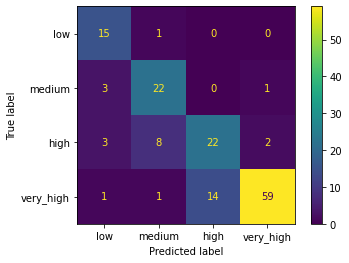

In [265]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model_labels = list(model.LABEL_DICT.values())

cm = confusion_matrix(y_relabeled, y_pred, labels=model_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model_labels)
disp.plot()
plt.show()


In [267]:
print(classification_report(y_relabeled, y_pred, target_names=model_labels))

              precision    recall  f1-score   support

         low       0.61      0.63      0.62        35
      medium       0.68      0.94      0.79        16
        high       0.69      0.85      0.76        26
   very_high       0.95      0.79      0.86        75

    accuracy                           0.78       152
   macro avg       0.73      0.80      0.76       152
weighted avg       0.80      0.78      0.78       152



### Checking class distribution in train and test sets

In [275]:
model_data_train.renewable_capita.value_counts()

3.0    864
1.0    854
2.0    829
0.0    767
Name: renewable_capita, dtype: int64

In [276]:
model_data_test.renewable_capita.value_counts()

3.0    75
2.0    35
1.0    26
0.0    16
Name: renewable_capita, dtype: int64